In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [15]:
current_dir = os.getcwd()
results = pd.read_csv(current_dir + '/MISA/results_mosei_MISA_dropout(0.6)-batchsize(32).csv')

In [17]:
results_json = current_dir + '/MISA/results_MISA_baseline_dropout(0.6)-batchsize(32)_epoch(40).json'
with open(results_json) as f:
    results_dict = json.load(f)

results_dict

{'loss': 2.715327604176247,
 'accuracy': 0.4311,
 'precision': 0.4718620168702002,
 'recall': 0.5923818555397503,
 'f1': 0.5252978276103714,
 'acc_va': 0.2594,
 'acc_ta': 0.4215,
 'acc_tv': 0.3849,
 'acc_t': 0.4104,
 'acc_v': 0.2362,
 'acc_a': 0.2593}

In [18]:
'''confidNet results
labels: ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
'''
results.head()

,id,input_sentence,label,prediction,predicted_scores,tcp_TVA,tcp_AV,tcp_TA,tcp_TV,tcp_T,tcp_V,tcp_A
0,-6rXp3zJ3kc[1],very aware of many people are not until they g...,[0. 1. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0.],[0.72649425 0.12163459 0.27498698 0.23521447 0...,0.121635,0.448398,0.163330,0.117395,0.450664,0.552882,0.134557
1,-AUZQgSxyPQ[0],the perfect soul mate to the spot therapy brus...,[0. 0. 0. 0. 0. 1.],[1. 0. 0. 0. 0. 0.],[0.88869697 0.1349046 0.09349081 0.08931422 0...,0.159668,0.397697,0.202317,0.164076,0.415701,0.488722,0.169275
2,-6rXp3zJ3kc[2],so the answer to the question can i contribute...,[0. 1. 0. 0. 0. 0.],[0. 1. 0. 0. 0. 0.],[0.26202127 0.5962315 0.27988574 0.07816251 0...,0.596232,0.439852,0.643639,0.551779,0.441278,0.542102,0.579935
3,-MeTTeMJBNc[3],picture maybe you could find a picture of the ...,[1. 0. 0. 1. 0. 0.],[1. 0. 0. 0. 0. 0.],[0.71148974 0.15403533 0.2314424 0.23259604 0...,0.472043,0.369023,0.516972,0.405853,0.322918,0.413531,0.473883
4,-RfYyzHpjk4[3],time you can use it for personal use family fr...,[1. 0. 1. 0. 1. 0.],[1. 0. 0. 0. 0. 0.],[0.7324562 0.15792662 0.10951347 0.09004372 0...,0.294074,0.283460,0.344160,0.261162,0.285849,0.365747,0.334096


In [19]:
print(len(results))

4654


In [20]:
results['label'].loc[lambda x: x =='[0. 0. 0. 0. 0. 0.]'].count()

701

In [21]:
# Drop the rows with no label
results = results[results['label'] != '[0. 0. 0. 0. 0. 0.]']
print(results.shape[0])

3953


In [22]:
text_is_noise = results[results['tcp_AV'] > results['tcp_TVA']]
audio_is_noise = results[results['tcp_TA'] > results['tcp_TVA']]
video_is_noise = results[results['tcp_TV'] > results['tcp_TVA']]

In [23]:
# Modality noise counts with no label rows dropped
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  3953
Textual noise counts:  1430
Visual noise counts:  1111
Audio noise counts:  3936


Text(0, 0.5, 'TCP difference')

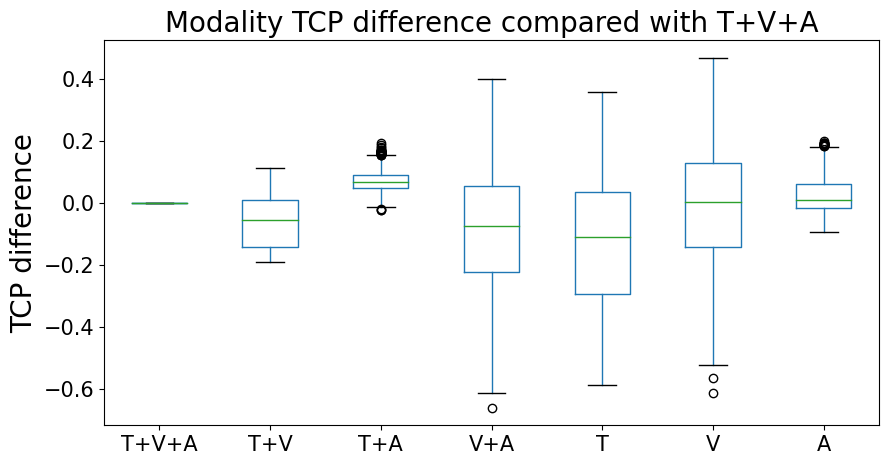

In [37]:
df_diff = pd.DataFrame()
df_diff['T+V+A'] = results['tcp_TVA'] - results['tcp_TVA']
df_diff['T+V'] = results['tcp_TV'] - results['tcp_TVA']
df_diff['T+A'] = results['tcp_TA'] - results['tcp_TVA']
df_diff['V+A'] = results['tcp_AV'] - results['tcp_TVA']
df_diff['T'] = results['tcp_T'] - results['tcp_TVA']
df_diff['V'] = results['tcp_V'] - results['tcp_TVA']
df_diff['A'] = results['tcp_A'] - results['tcp_TVA']

box = df_diff.boxplot(column=['T+V+A', 'T+V', 'T+A', 'V+A', 'T', 'V', 'A'], figsize=(10, 5), grid=False, fontsize=15)
box.set_title('Modality TCP difference compared with T+V+A', fontsize=20)
box.set_ylabel('TCP difference', fontsize=20)

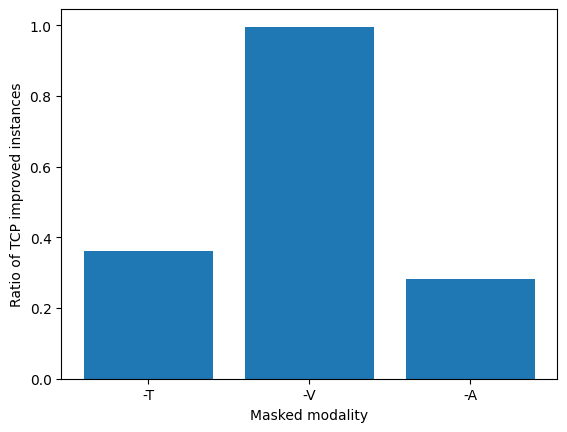

In [40]:
# Ratio of TCP improved instances for each modality masking
columns = ['-T', '-V', '-A']

tcp_improved_ratio = [
    (results['tcp_AV'] > results['tcp_TVA']).sum() / results.shape[0],
    (results['tcp_TA'] > results['tcp_TVA']).sum() / results.shape[0],
    (results['tcp_TV'] > results['tcp_TVA']).sum() / results.shape[0]
]

plt.bar(columns, tcp_improved_ratio)
plt.xlabel("Masked modality")
plt.ylabel("Ratio of TCP improved instances")
plt.show()

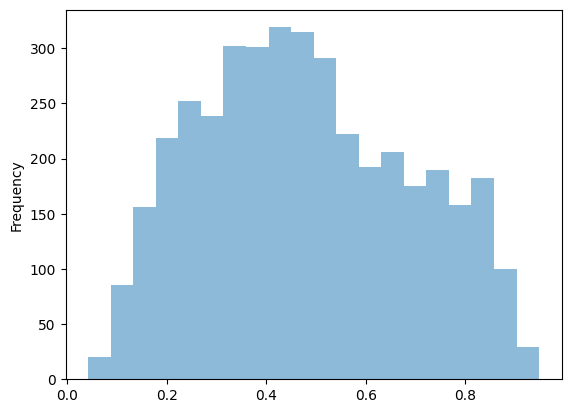

In [24]:
ax = results['tcp_TVA'].plot.hist(bins=20, alpha=0.5)

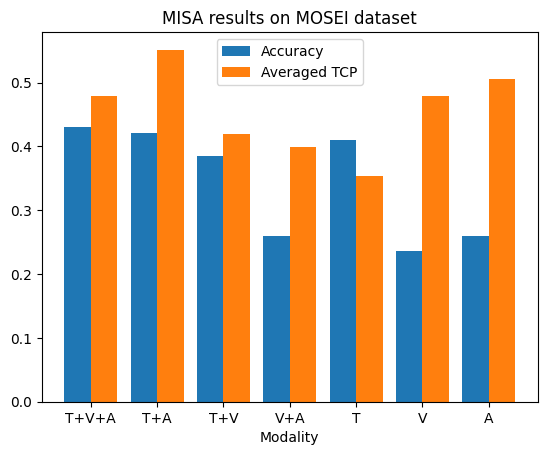

In [25]:
columns = ['T+V+A', 'T+A', 'T+V', 'V+A', 'T', 'V', 'A']
X_axis = np.arange(len(columns))

accuracy = [
    results_dict['accuracy'], results_dict['acc_ta'], results_dict['acc_tv'], results_dict['acc_va'], results_dict['acc_t'], results_dict['acc_v'], results_dict['acc_a']
]

average_tcp = [
    np.mean(results['tcp_TVA']), 
    np.mean(results['tcp_TA']), 
    np.mean(results['tcp_TV']), 
    np.mean(results['tcp_AV']), 
    np.mean(results['tcp_T']),
    np.mean(results['tcp_V']), 
    np.mean(results['tcp_A'])
]

# histogram of the data
plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, average_tcp, 0.4, label = 'Averaged TCP')

plt.xticks(X_axis, columns)
plt.xlabel("Modality")
plt.title("MISA results on MOSEI dataset")
plt.legend()
plt.show()

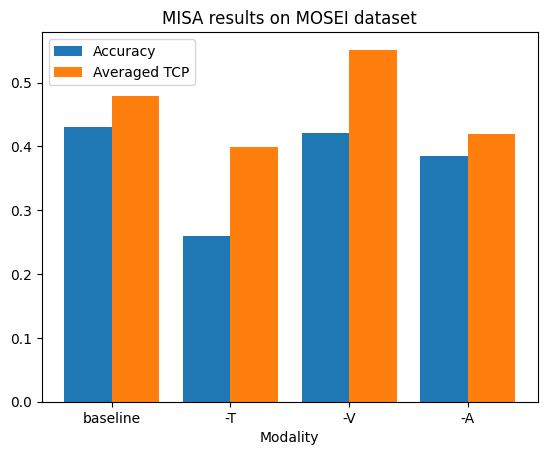

In [27]:
columns = ['baseline','-T', '-V', '-A']
X_axis = np.arange(len(columns))

accuracy = [
    results_dict['accuracy'], results_dict['acc_va'], results_dict['acc_ta'], results_dict['acc_tv']
]

average_tcp = [
    np.mean(results['tcp_TVA']), 
    np.mean(results['tcp_AV']), 
    np.mean(results['tcp_TA']), 
    np.mean(results['tcp_TV']), 
]

# histogram of the data
plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, average_tcp, 0.4, label = 'Averaged TCP')

plt.xticks(X_axis, columns)
plt.xlabel("Modality")
plt.title("MISA results on MOSEI dataset")
plt.legend()
plt.show()

<Axes: title={'center': 'Frequency of top-1 confidence for each instance'}>

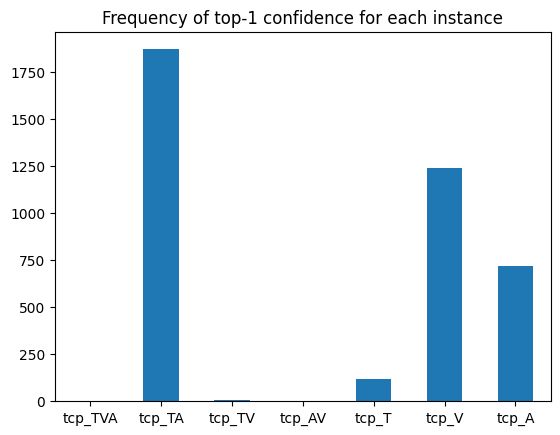

In [28]:
columns = ['tcp_TVA', 'tcp_TA', 'tcp_TV', 'tcp_AV', 'tcp_T', 'tcp_V', 'tcp_A']
results['top_1_column'] = results[['tcp_TVA','tcp_TV','tcp_TA', 'tcp_AV', 'tcp_T', 'tcp_V', 'tcp_A']].idxmax(axis=1)
df = results['top_1_column'].value_counts(sort=False)
for col in columns:
    if col not in df.index:
        df[col] = 0
df.loc[columns].plot.bar(rot=0, x=columns, title="Frequency of top-1 confidence for each instance")

<Axes: title={'center': 'Frequency of top-1 confidence for each instance'}>

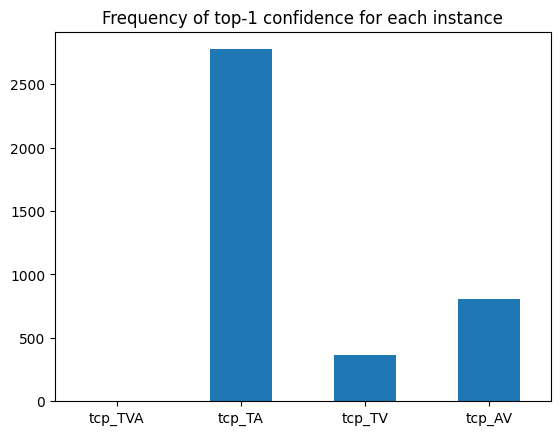

In [30]:
columns = ['tcp_TVA', 'tcp_TA', 'tcp_TV', 'tcp_AV']
results['top_1_column'] = results[['tcp_TVA','tcp_TV','tcp_TA', 'tcp_AV']].idxmax(axis=1)
df = results['top_1_column'].value_counts(sort=False)
for col in columns:
    if col not in df.index:
        df[col] = 0
df.loc[columns].plot.bar(rot=0, x=columns, title="Frequency of top-1 confidence for each instance")

<Axes: title={'center': 'Frequency of top-1 confidence for each instance'}>

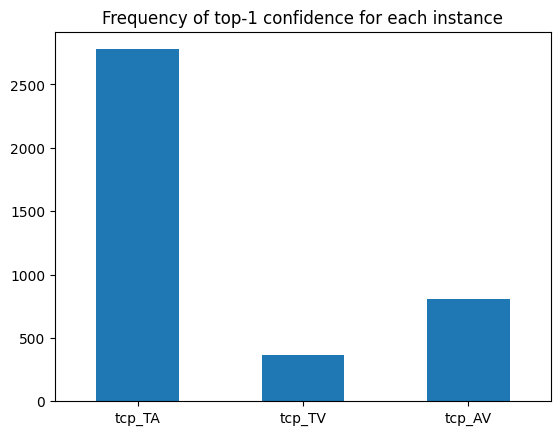

In [31]:
columns = ['tcp_TA', 'tcp_TV', 'tcp_AV']
results['top_1_column'] = results[['tcp_TV','tcp_TA', 'tcp_AV']].idxmax(axis=1)
df = results['top_1_column'].value_counts(sort=False)
for col in columns:
    if col not in df.index:
        df[col] = 0
df.loc[columns].plot.bar(rot=0, x=columns, title="Frequency of top-1 confidence for each instance")